In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import random
import seaborn as sns
from gym import spaces
import time
from IPython.display import clear_output
import os
from PIL import Image
import imageio
from matplotlib.animation import FuncAnimation, PillowWriter

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
os.makedirs('output/gifs', exist_ok=True)
os.makedirs('output/plots', exist_ok=True)
os.makedirs('output/models', exist_ok=True)

print("✅ Libraries loaded successfully!")
print("📁 Output directories created: output/gifs, output/plots, output/models")

✅ Libraries loaded successfully!
📁 Output directories created: output/gifs, output/plots, output/models


In [4]:
def create_gridworld(height=5, width=5, start=(0,0)):
    """
    Create a generic GridWorld environment with customizable dimensions.
    
    Args:
        height: Grid height
        width: Grid width
        start: Starting position tuple (row, col)
    
    Returns:
        env: Dictionary containing environment configuration
    """
    
    # Generate two distinct goal positions
    goal1 = (random.randint(0, height-1), random.randint(0, width-1))
    while True:
        goal2 = (random.randint(0, height-1), random.randint(0, width-1))
        if goal2 != goal1:
            break

    # Generate obstacle that doesn't collide with start or goals
    while True:
        obstacle = (random.randint(0, height-1), random.randint(0, width-1))
        if obstacle not in [goal1, goal2, start]:
            break
    
    env = {
        "height": height,
        "width": width,
        "start": np.array(start, dtype=int),
        "goal1": np.array(goal1, dtype=int),
        "goal2": np.array(goal2, dtype=int),
        "agent_pos": np.array(start, dtype=int),
        "obstacle": np.array(obstacle, dtype=int),
        "observation_space": spaces.MultiDiscrete([height, width]),
        "action_space": spaces.Discrete(4)
    }
    
    return env

In [5]:
def reset(env, randomize=False):
    """
    Reset the environment.
    
    Args:
        env: Environment dictionary
        randomize: If True, regenerate goals and obstacle positions
    """
    if randomize:
        height = env["height"]
        width = env["width"]
        start = tuple(env["start"])
        
        # Regenerate goals
        goal1 = (random.randint(0, height-1), random.randint(0, width-1))
        while True:
            goal2 = (random.randint(0, height-1), random.randint(0, width-1))
            if goal2 != goal1:
                break
        
        # Regenerate obstacle
        while True:
            obstacle = (random.randint(0, height-1), random.randint(0, width-1))
            if obstacle not in [goal1, goal2, start]:
                break
        
        env["goal1"] = np.array(goal1, dtype=int)
        env["goal2"] = np.array(goal2, dtype=int)
        env["obstacle"] = np.array(obstacle, dtype=int)
    
    env["agent_pos"] = env["start"].copy()
    return env["agent_pos"]


In [6]:
def step(env, action):
    """
    Execute action in the environment.
    
    Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
    """
    r, c = env["agent_pos"]
    height = env["height"]
    width = env["width"]

    # Proposed new position
    new_r, new_c = r, c
    if action == 0:      # UP
        new_r = max(0, r - 1)
    elif action == 1:    # RIGHT
        new_c = min(width - 1, c + 1)
    elif action == 2:    # DOWN
        new_r = min(height - 1, r + 1)
    elif action == 3:    # LEFT
        new_c = max(0, c - 1)

    proposed_pos = np.array([new_r, new_c])

    # Check obstacle
    if np.array_equal(proposed_pos, env["obstacle"]):
        reward = -5
        done = False
        new_pos = env["agent_pos"].copy()
    # Check goals
    elif np.array_equal(proposed_pos, env["goal1"]) or np.array_equal(proposed_pos, env["goal2"]):
        reward = 10
        done = True
        new_pos = proposed_pos
    else:
        reward = -1
        done = False
        new_pos = proposed_pos

    env["agent_pos"] = new_pos
    return new_pos, reward, done


In [7]:
def render_plot(env, ax=None, title="GridWorld Environment"):
    """Render the grid with agent, goals, and obstacle."""
    height = env["height"]
    width = env["width"]
    grid = np.zeros((height, width))

    # Get positions
    r, c = env["agent_pos"]
    g1r, g1c = env["goal1"]
    g2r, g2c = env["goal2"]
    orr, orc = env["obstacle"]

    # Assign values
    grid[orr, orc] = 3
    grid[g1r, g1c] = 2
    grid[g2r, g2c] = 2
    grid[r, c] = 1

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.clear()
    ax.imshow(grid, cmap="Pastel1", origin="upper")
    ax.set_xticks(range(width))
    ax.set_yticks(range(height))
    ax.grid(True, which="both", color="black", linewidth=1)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    return ax

In [8]:
def initialize_network(state_size=2, action_size=4, hidden_size=64):
    """
    Initialize neural network weights.
    
    Returns:
        weights: Dictionary containing W1, b1, W2, b2
    """
    weights = {
        'W1': np.random.randn(state_size, hidden_size) * np.sqrt(2.0 / state_size),
        'b1': np.zeros((1, hidden_size)),
        'W2': np.random.randn(hidden_size, action_size) * np.sqrt(2.0 / hidden_size),
        'b2': np.zeros((1, action_size))
    }
    return weights

In [9]:
def relu(x):
    """ReLU activation function."""
    return np.maximum(0, x)


def relu_derivative(x):
    """Derivative of ReLU."""
    return (x > 0).astype(float)

In [10]:
def forward_pass(state, weights):
    """
    Forward pass through the network.
    
    Args:
        state: Input state [batch_size, 2] normalized
        weights: Network weights dictionary
    
    Returns:
        q_values: Q-values for all actions
        cache: Dictionary with intermediate values for backprop
    """
    # Hidden layer
    z1 = np.dot(state, weights['W1']) + weights['b1']
    a1 = relu(z1)
    
    # Output layer
    z2 = np.dot(a1, weights['W2']) + weights['b2']
    q_values = z2
    
    cache = {'z1': z1, 'a1': a1, 'z2': z2, 'state': state}
    return q_values, cache


In [11]:
def backward_pass(cache, weights, action, td_error, learning_rate):
    """
    Backward pass - update weights using gradient descent.
    
    Args:
        cache: Cached values from forward pass
        weights: Network weights dictionary
        action: Action taken (integer or array)
        td_error: Temporal difference error
        learning_rate: Learning rate
    
    Returns:
        weights: Updated weights dictionary
    """
    batch_size = cache['state'].shape[0]
    
    # Output layer gradients
    dL_dz2 = np.zeros_like(cache['z2'])
    if isinstance(action, int):
        dL_dz2[0, action] = -td_error
    else:
        dL_dz2[np.arange(batch_size), action] = -td_error
    
    dW2 = np.dot(cache['a1'].T, dL_dz2) / batch_size
    db2 = np.sum(dL_dz2, axis=0, keepdims=True) / batch_size
    
    # Hidden layer gradients
    dL_da1 = np.dot(dL_dz2, weights['W2'].T)
    dL_dz1 = dL_da1 * relu_derivative(cache['z1'])
    
    dW1 = np.dot(cache['state'].T, dL_dz1) / batch_size
    db1 = np.sum(dL_dz1, axis=0, keepdims=True) / batch_size
    
    # Update weights
    weights['W1'] -= learning_rate * dW1
    weights['b1'] -= learning_rate * db1
    weights['W2'] -= learning_rate * dW2
    weights['b2'] -= learning_rate * db2
    
    return weights

In [12]:
def normalize_state(state, height, width):
    """Normalize state coordinates to [0, 1] range."""
    return np.array([[state[0] / height, state[1] / width]])

In [13]:
def select_action(weights, state, height, width, epsilon):
    """
    Epsilon-greedy action selection.
    
    Args:
        weights: Network weights
        state: Current state [row, col]
        height, width: Grid dimensions
        epsilon: Exploration rate
    
    Returns:
        action: Selected action (0-3)
    """
    if np.random.rand() < epsilon:
        return np.random.randint(0, 4)  # Explore
    else:
        state_norm = normalize_state(state, height, width)
        q_values, _ = forward_pass(state_norm, weights)
        return np.argmax(q_values[0])  # Exploit


def save_weights(weights, filepath):
    """Save network weights."""
    np.savez(filepath, **weights)
    print(f"✅ Model saved to {filepath}")


def load_weights(filepath):
    """Load network weights."""
    data = np.load(filepath)
    weights = {key: data[key] for key in data.files}
    print(f"✅ Model loaded from {filepath}")
    return weights


In [22]:
def train_agent(env, episodes=500, max_steps=100, gamma=0.95, 
                epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                learning_rate=0.001, hidden_size=64):
    """
    Train the agent using Q-learning with neural network approximation.
    
    Args:
        env: GridWorld environment
        episodes: Number of training episodes
        max_steps: Maximum steps per episode
        gamma: Discount factor
        epsilon_start: Initial exploration rate
        epsilon_end: Final exploration rate
        epsilon_decay: Epsilon decay rate
        learning_rate: Learning rate for neural network
        hidden_size: Hidden layer size
    
    Returns:
        weights: Trained network weights
        history: Dictionary with training history
    """
    height = env["height"]
    width = env["width"]
    
    # Initialize network
    weights = initialize_network(state_size=2, action_size=4, hidden_size=hidden_size)
    
    # Training history
    rewards_history = []
    steps_history = []
    epsilon = epsilon_start
    
    print("🚀 Starting training...")
    print(f"Episodes: {episodes}, Max Steps: {max_steps}")
    print(f"Gamma: {gamma}, Learning Rate: {learning_rate}")
    print("-" * 60)
    
    for episode in range(episodes):
        state = reset(env, randomize=True)
        total_reward = 0
        
        for step_count in range(max_steps):
            # Select action
            action = select_action(weights, state, height, width, epsilon)
            
            # Take action
            next_state, reward, done = step(env, action)
            total_reward += reward
            
            # Normalize states
            state_norm = normalize_state(state, height, width)
            next_state_norm = normalize_state(next_state, height, width)
            
            # Get Q-values
            q_values, cache = forward_pass(state_norm, weights)
            next_q_values, _ = forward_pass(next_state_norm, weights)
            
            # Compute target Q-value (Q-learning)
            if done:
                target_q = reward
            else:
                target_q = reward + gamma * np.max(next_q_values)
            
            # Compute TD error
            current_q = q_values[0, action]
            td_error = target_q - current_q
            
            # Update network
            weights = backward_pass(cache, weights, action, td_error, learning_rate)
            
            state = next_state
            
            if done:
                break
        
        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        
        # Store history
        rewards_history.append(total_reward)
        steps_history.append(step_count + 1)
        
        # Print progress
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(rewards_history[-50:])
            avg_steps = np.mean(steps_history[-50:])
            print(f"Episode {episode+1}/{episodes} | Avg Reward: {avg_reward:.2f} | "
                  f"Avg Steps: {avg_steps:.2f} | Epsilon: {epsilon:.3f}")
    
    print("-" * 60)
    print("✅ Training completed!")
    
    # Save model
    save_weights(weights, 'output/models/q_network.npz')
    
    # Plot training curves
    plot_training_curves(rewards_history, steps_history)
    
    history = {
        'rewards': rewards_history,
        'steps': steps_history
    }
    
    return weights, history

In [23]:
def plot_training_curves(rewards_history, steps_history):
    """Plot training performance over episodes."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Rewards plot
    axes[0].plot(rewards_history, alpha=0.3, color='blue')
    window = 50
    if len(rewards_history) >= window:
        moving_avg = pd.Series(rewards_history).rolling(window=window).mean()
        axes[0].plot(moving_avg, color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
        axes[0].legend()
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].set_title('Training Rewards Over Time')
    axes[0].grid(True, alpha=0.3)
    
    # Steps plot
    axes[1].plot(steps_history, alpha=0.3, color='green')
    if len(steps_history) >= window:
        moving_avg = pd.Series(steps_history).rolling(window=window).mean()
        axes[1].plot(moving_avg, color='red', linewidth=2, label=f'{window}-Episode Moving Avg')
        axes[1].legend()
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Steps to Goal')
    axes[1].set_title('Training Steps Over Time')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('output/plots/training_curves.png', dpi=150, bbox_inches='tight')
    print("📊 Training curves saved to output/plots/training_curves.png")
    plt.show()


In [24]:
def test_agent(env, weights, episodes=5, max_steps=50, render_gif=True):
    """
    Test the trained agent and visualize its behavior.
    
    Args:
        env: GridWorld environment
        weights: Trained network weights
        episodes: Number of test episodes
        max_steps: Maximum steps per episode
        render_gif: Whether to create GIF animations
    
    Returns:
        results: Dictionary with test statistics
    """
    height = env["height"]
    width = env["width"]
    
    test_rewards = []
    test_steps = []
    success_count = 0
    
    print("🧪 Testing trained agent...")
    print("-" * 60)
    
    for episode in range(episodes):
        state = reset(env, randomize=True)
        frames = []
        total_reward = 0
        
        # Create figure for rendering
        if render_gif:
            fig, ax = plt.subplots(figsize=(6, 6))
        
        for step_count in range(max_steps):
            # Render current state
            if render_gif:
                render_plot(env, ax=ax, title=f"Test Episode {episode+1} - Step {step_count+1}")
                fig.canvas.draw()
                img = np.array(fig.canvas.renderer.buffer_rgba())
                img = img[:, :, :3]  # Remove alpha channel
                frames.append(img)
            
            # Select action (greedy - no exploration)
            state_norm = normalize_state(state, height, width)
            q_values, _ = forward_pass(state_norm, weights)
            action = np.argmax(q_values[0])
            
            # Take action
            next_state, reward, done = step(env, action)
            total_reward += reward
            state = next_state
            
            if done:
                # Render final state
                if render_gif:
                    render_plot(env, ax=ax, title=f"Test Episode {episode+1} - GOAL! (Step {step_count+1})")
                    fig.canvas.draw()
                    img = np.array(fig.canvas.renderer.buffer_rgba())
                    img = img[:, :, :3]  # Remove alpha channel
                    frames.append(img)
                    # Hold final frame
                    for _ in range(5):
                        frames.append(img)
                
                success_count += 1
                break
        
        if render_gif:
            plt.close(fig)
        
        test_rewards.append(total_reward)
        test_steps.append(step_count + 1)
        
        # Save GIF for this episode
        if render_gif and len(frames) > 0:
            gif_path = f'output/gifs/test_episode_{episode+1}.gif'
            imageio.mimsave(gif_path, frames, fps=3)
            print(f"✅ Episode {episode+1}: Reward={total_reward}, Steps={step_count+1}, GIF saved to {gif_path}")
        else:
            print(f"✅ Episode {episode+1}: Reward={total_reward}, Steps={step_count+1}")
    
    print("-" * 60)
    print(f"📈 Test Results Summary:")
    print(f"   Success Rate: {success_count}/{episodes} ({100*success_count/episodes:.1f}%)")
    print(f"   Average Reward: {np.mean(test_rewards):.2f}")
    print(f"   Average Steps: {np.mean(test_steps):.2f}")
    
    results = {
        'rewards': test_rewards,
        'steps': test_steps,
        'success_rate': success_count / episodes
    }
    
    return results

🌍 Creating GridWorld environment...
   Grid Size: 5x5
   Start: [0 0]
   Goal 1: [0 3]
   Goal 2: [0 1]
   Obstacle: [3 2]

🚀 Starting training...
Episodes: 500, Max Steps: 100
Gamma: 0.95, Learning Rate: 0.001
------------------------------------------------------------
Episode 50/500 | Avg Reward: -22.20 | Avg Steps: 28.06 | Epsilon: 0.778
Episode 100/500 | Avg Reward: -24.46 | Avg Steps: 29.86 | Epsilon: 0.606
Episode 150/500 | Avg Reward: -49.02 | Avg Steps: 52.76 | Epsilon: 0.471
Episode 200/500 | Avg Reward: -67.68 | Avg Steps: 69.76 | Epsilon: 0.367
Episode 250/500 | Avg Reward: -53.36 | Avg Steps: 55.96 | Epsilon: 0.286
Episode 300/500 | Avg Reward: -77.08 | Avg Steps: 78.72 | Epsilon: 0.222
Episode 350/500 | Avg Reward: -63.28 | Avg Steps: 66.52 | Epsilon: 0.173
Episode 400/500 | Avg Reward: -69.20 | Avg Steps: 71.80 | Epsilon: 0.135
Episode 450/500 | Avg Reward: -68.14 | Avg Steps: 69.88 | Epsilon: 0.105
Episode 500/500 | Avg Reward: -72.78 | Avg Steps: 75.20 | Epsilon: 0.082

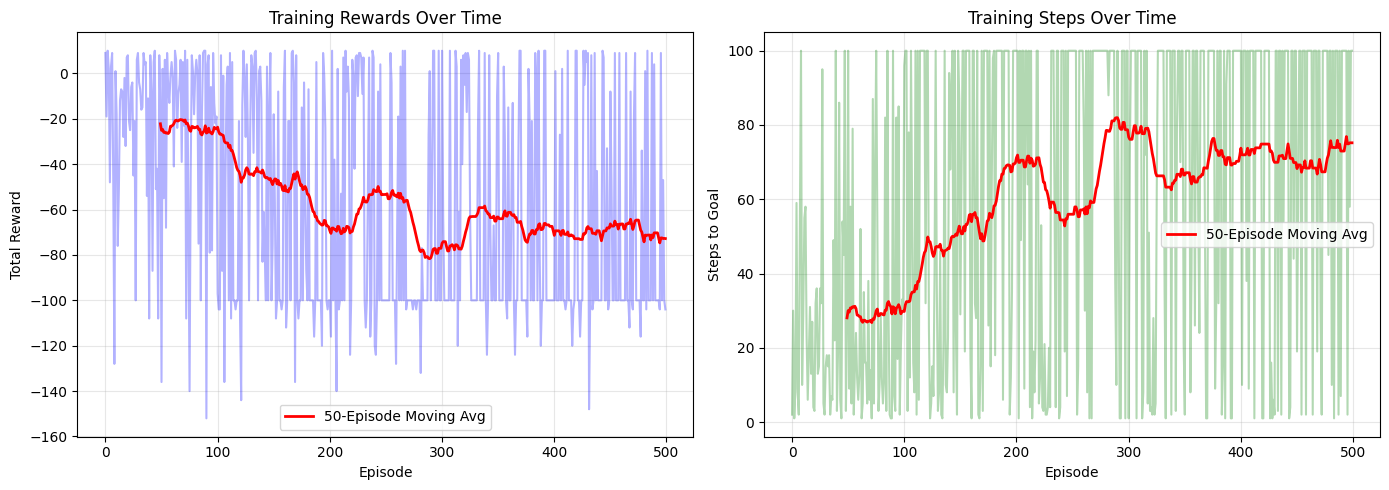


🧪 Testing trained agent...
------------------------------------------------------------
✅ Episode 1: Reward=-50, Steps=50, GIF saved to output/gifs/test_episode_1.gif
✅ Episode 2: Reward=-50, Steps=50, GIF saved to output/gifs/test_episode_2.gif
✅ Episode 3: Reward=-50, Steps=50, GIF saved to output/gifs/test_episode_3.gif
✅ Episode 4: Reward=-50, Steps=50, GIF saved to output/gifs/test_episode_4.gif
✅ Episode 5: Reward=-50, Steps=50, GIF saved to output/gifs/test_episode_5.gif
------------------------------------------------------------
📈 Test Results Summary:
   Success Rate: 0/5 (0.0%)
   Average Reward: -50.00
   Average Steps: 50.00

🎉 All done! Check the 'output' folder for results:
   📁 output/models/ - Trained neural network weights
   📁 output/plots/ - Training performance curves
   📁 output/gifs/ - Agent behavior animations


In [25]:
# Create environment
print("🌍 Creating GridWorld environment...")
env = create_gridworld(height=5, width=5, start=(0, 0))
print(f"   Grid Size: {env['height']}x{env['width']}")
print(f"   Start: {env['start']}")
print(f"   Goal 1: {env['goal1']}")
print(f"   Goal 2: {env['goal2']}")
print(f"   Obstacle: {env['obstacle']}")
print()

# Train the agent
weights, history = train_agent(
    env,
    episodes=500,
    max_steps=100,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    learning_rate=0.001,
    hidden_size=64
)
print()

# Test the agent
results = test_agent(env, weights, episodes=5, max_steps=50, render_gif=True)
print()

print("🎉 All done! Check the 'output' folder for results:")
print("   📁 output/models/ - Trained neural network weights")
print("   📁 output/plots/ - Training performance curves")
print("   📁 output/gifs/ - Agent behavior animations")